# Final Project: Apple Twitter Sentiment Analysis
Author: Aidan Sullivan

## Project Description 

Data Source: CSV available at - https://data.world/crowdflower/apple-twitter-sentiment

Scope: The primary purpose of this project is to take a CSV, stage the data in a SQL database and read in the data with Python through the pandas library with a staged data frame for the data science process. Staging the data in a tool like SSMS demonstrates real-use business cases of daily data analysis, by creating a connection between the data source and the Jupyter notebook.

Method Of Analysis: After data loading and cleaning, exploratory data analysis will be conducted to generate the distribution of tweets per day, trending hashtags and mentions, and the distirbution of lengths per tweet. Next portion of the project will conduct sentiment analysis of the tweets' text utilizing the 'pattern' and 'vader' library packages. Each package has a unique way of calculating a sentiment score for text, the difference between the scores will be conducted to analyze the distribution between the two scores. Finally, a stock analysis is generated to identify the correlation between Apple stock daily returns and the daily sentiment. 
    Questions that will be covered:
        "Who or what is trending from the apples via mentions and hashatags?"
        "What is the daily proportion of tweets sentiment?"
        "Is there a correlation between daily tweet sentiment and stock pefromance?" 
    Fields: The dataset will be greatly reduced from the original version available, the original dataset has sentiment scores 
            and query related data. These will be dropped for an unbias analysis to create original analysis andconclusions. 

SQL Script to create database and stage data to SSMS:
    
    create database school
    go

    use school
    go 

    drop table if exists twitter
    
    -- Column headers are an exact match to the csv 
    create table twitter (
         [_unit_id] varchar(50) 
        ,[_golden] varchar(10)
        ,[_unit_state] varchar(25)
        ,[_trusted_judgments] int 
        ,[_last_judgment_at] varchar(25)
        ,[sentiment] varchar(50)
        ,[sentiment:confidence] numeric(5,4)
        ,[date] varchar(50)
        ,[id] bigint
        ,[query] varchar(20)
        ,[sentiment_gold] varchar(20)
        ,[text] varchar(max)
        )

    -- Replace source file path with loaction of the downloaded csv
    bulk insert twitter 
    from 'C:\Users\14108\Documents\Apple-Twitter-Sentiment-DFE.csv'
    with ( 
             format = 'CSV'
            ,firstrow = 2
            );

    select * from school.dbo.twitter  


## Analysis

In [1]:
#pip install pyodbc

In [2]:
#pip install missingno

In [ ]:
#pip install pattern

In [ ]:
#pip install vaderSentiment

In [ ]:
#pip install yfinance

### Preprocessing & Data Cleaning

The following portion loads the required packages to execute the scope of the project. The second portion, checks the ODBC drivers to create the connection for Microsoft SQL Server. While creating this project, the main issues with connecting SSMS to access the 'school' database was due to driver connectivity issues. The output ensures the specific driver to access. If issues are incurred connecting the database to the notebook with creating an SSMS connection, check the environment variables are added to the system path, the ODBC drivers are up-to-date, and/or create a DNS connection. The driver used for this analysis at time is "ODBC Driver 18 for SQL Server", additional drivers will need to be downloaded as SSMS is updated and the ODBC driver is still supported. If program is being ran in Google Colab, import 'pyodbc' and then print the drivers to see if drivers are available. Initially at this time of the creation of this project Google Colab was not connecting properly with the ODBC drives.

In [1]:
import pandas as pd 
import pyodbc 
import re
import missingno as msno
import matplotlib.pyplot as pt 
from pattern.en import sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as sia
from yfinance import download
import nltk
nltk.download('omw-1.4')

# Check SQL Server Drivers available on local machine
for driver in pyodbc.drivers():
  print(driver)

SQL Server
SQL Server Native Client RDA 11.0
SQL Server Native Client 11.0
PostgreSQL ANSI(x64)
PostgreSQL Unicode(x64)
Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)
ODBC Driver 17 for SQL Server
ODBC Driver 18 for SQL Server
Microsoft Access Driver (*.mdb, *.accdb)
Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)
Microsoft Access Text Driver (*.txt, *.csv)


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\14108\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def get_data(connection_string, query):
    try:
        conn = pyodbc.connect(connection_string)
    except pyodbc.Error as e:
        print("Error while connecting to the database:")
        print(e)
        return None
    
    try:
        # Create cursor
        cursor = conn.cursor()
        
        # Execute query
        cursor.execute(query)
        
        # Get rows
        rows = cursor.fetchall()
        
        # Extract column names from cursor description, Remove Special Characters from column names
        column_names = [re.sub(r'[^a-zA-Z0-9_]', '', column[0]) for column in cursor.description]
        
        # Unpack the rows into separate columns
        transposed_rows = list(zip(*rows))
        
        # Create a dictionary with column names as keys and transposed rows as values
        data_dict = {column: values for column, values in zip(column_names, transposed_rows)}
        
        # Create a Pandas DataFrame from the dictionary
        df = pd.DataFrame(data_dict)
        
        return df
        
    finally:
        # Close the cursor and the connection, Connection will close if error during data retrieval
        cursor.close()
        conn.close()

In [3]:
# Maunal fields to update to run functions 

# Connection String 
connection_string = (
    "DRIVER={ODBC Driver 18 for SQL Server};"
    "SERVER=DESKTOP-LKS1HQD\\SQLEXPRESS01;"
    "DATABASE=school;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)
# SQL query defined
query = "SELECT * FROM school.dbo.twitter"

# Run function for data retrieval from SQL Server 
data = get_data(connection_string,query)
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentimentconfidence,date,id,query,sentiment_gold,text
0,623495513,TRUE,golden,10,None,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,540000000000000000,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,TRUE,golden,12,None,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,540000000000000000,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,TRUE,golden,10,None,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,540000000000000000,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,TRUE,golden,17,None,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,540000000000000000,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,FALSE,finalized,3,12/12/2014 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,540000000000000000,#AAPL OR @Apple,None,Nobody expects the Spanish Inquisition #AAPL


<Axes: >

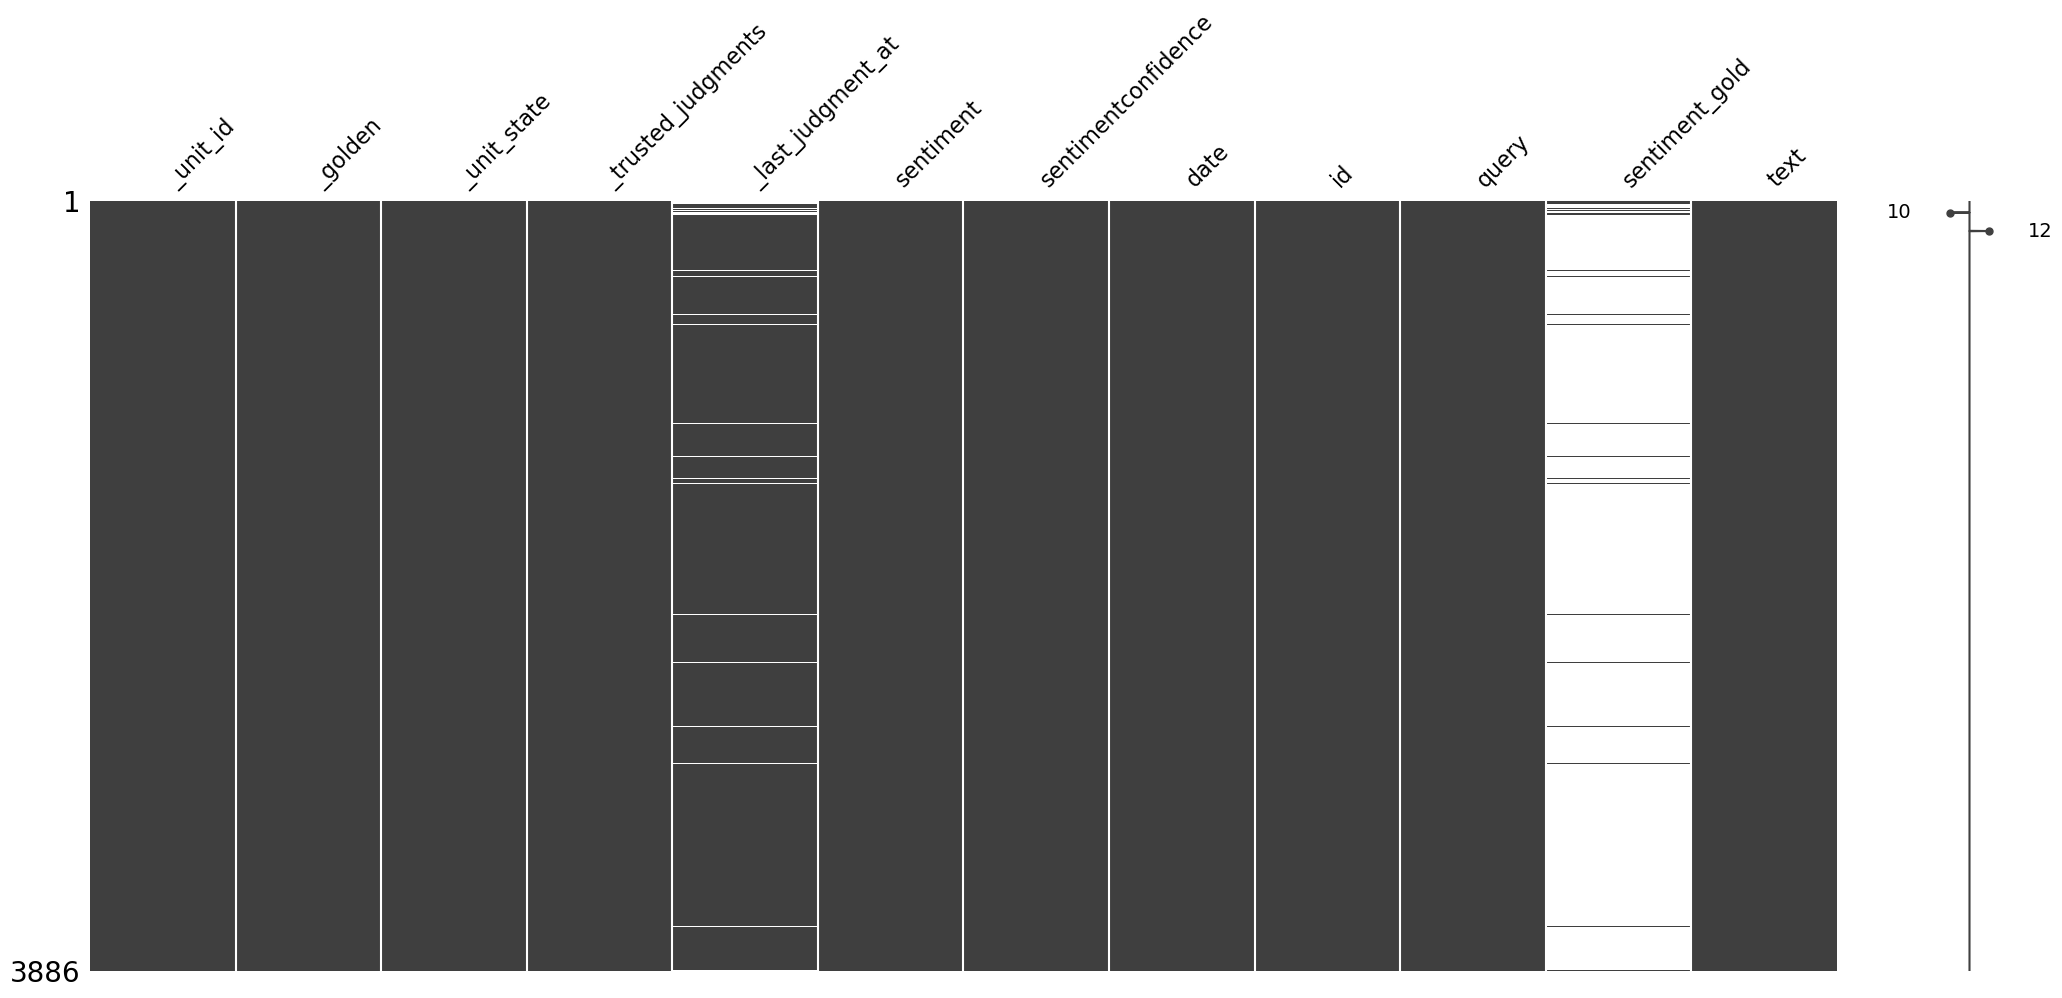

In [4]:
# Observe missing values within the dataset
msno.matrix(data)

In [5]:
def clean(df, columns_to_rename=None, columns_to_drop=None, rename_value=None, date_format=None, date2_format=None, date_time_format=None):
    if columns_to_rename:
        for col_mapping in columns_to_rename:
            old_col_name = col_mapping['old']
            new_col_name = col_mapping['new']
            df = df.rename(columns={old_col_name: new_col_name})

    if columns_to_drop:
        df.drop(columns_to_drop, axis=1, inplace=True)

    # Convert all column names to lower case
    df.columns = df.columns.str.lower()

    # Double-check for in filtered down df missing values
    missing_values = df.isna().sum()
    print("\nCheck for missing values")
    print(missing_values)

    if date_format:
        # Convert date from Twitter date config to workable dates
        df['date'] = pd.to_datetime(df['date'], format=date_format)

        if date2_format:
            # Split "date" into two separate columns
            df['date2'] = df['date'].dt.strftime(date2_format)
        if date_time_format:
            df['date_time'] = df['date'].dt.strftime(date_time_format)
            
    # Clean text in Tweets, Convert all to lowercase then Remove URLs from the Tweet Text 
    if 'text' in df.columns:
        # Convert text in the 'text' column to lowercase
        df['text'] = df['text'].str.lower()
        
        # Remove URLs from the 'text' column
        df['text'] = df['text'].str.replace(r'http[^ ]*', '', regex=True)

    return df

In [6]:
# Initial date format conversion - '%a %b %d %H:%M:%S %z %Y'
# Date format for yyyy-mm-dd - '%Y-%m-%d'
# Date format for hours, minutes, seconds - '%H:%M:%S %z'

columns_to_rename = [{'old': '_unit_id', 'new': 'unit_id'}]
rename_value = '_'
columns_to_drop = ['_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'sentiment',
                   'sentimentconfidence','id', 'query', 'sentiment_gold']

# Clean the dataset
# The clean function does not remove special characters at this point, special characters of the tweets '@' and '#'
df = clean(data,
           columns_to_rename=columns_to_rename,
           columns_to_drop=columns_to_drop,
           rename_value=rename_value,
           date_format='%a %b %d %H:%M:%S %z %Y',
           date2_format='%Y-%m-%d',
           date_time_format='%H:%M:%S %z')
df.head()



Check for missing values
unit_id    0
date       0
text       0
dtype: int64


,unit_id,date,text,date2,date_time
0,623495513,2014-12-01 19:30:03+00:00,#aapl:the 10 best steve jobs emails ever...,2014-12-01,19:30:03 +0000
1,623495514,2014-12-01 19:43:51+00:00,rt @jpdesloges: why aapl stock had a mini-flas...,2014-12-01,19:43:51 +0000
2,623495515,2014-12-01 19:50:28+00:00,my cat only chews @apple cords. such an #apple...,2014-12-01,19:50:28 +0000
3,623495516,2014-12-01 20:26:34+00:00,i agree with @jimcramer that the #individualin...,2014-12-01,20:26:34 +0000
4,623495517,2014-12-01 20:29:33+00:00,nobody expects the spanish inquisition #aapl,2014-12-01,20:29:33 +0000


In [7]:
# Drop the original date attribute
df.drop('date', axis=1, inplace=True)
# print(df.head())

### Exploratory Data Analysis

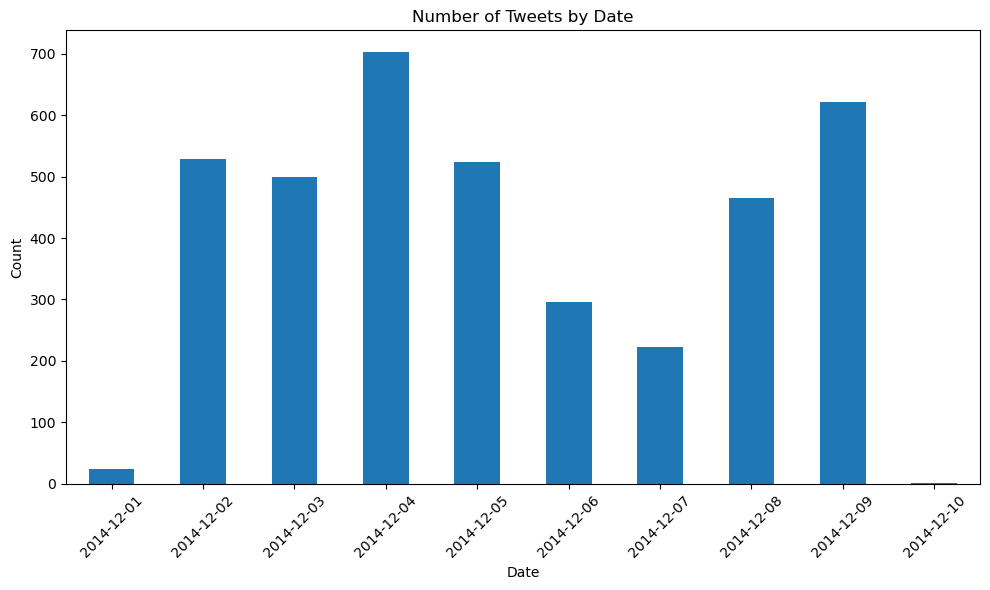

date2
2014-12-01     24
2014-12-02    529
2014-12-03    499
2014-12-04    703
2014-12-05    524
2014-12-06    296
2014-12-07    223
2014-12-08    465
2014-12-09    622
2014-12-10      1
dtype: int64


In [8]:
# Exploratory Data Analysis 
# Count the number of Tweets by date 
observations_by_date = df.groupby('date2').size()

# Create a bar chart
pt.figure(figsize=(10, 6))
observations_by_date.plot(kind='bar')
pt.xlabel('Date')
pt.ylabel('Count')
pt.title('Number of Tweets by Date')
pt.xticks(rotation=45)
pt.tight_layout()
pt.show()

print(observations_by_date)

To begin the exploratory analysis of the Apple tweets dataset, the  bar chart visualizes the number of tweets by date. It's evident from the chart that the first and last days of the dataset, namely December 1st and December 10th, exhibit notably fewer tweets compared to the other eight days in the dataset. In contrast, the remaining eight days show higher tweet activity and could be related to when the user ran the query or API to genreate the dataset.

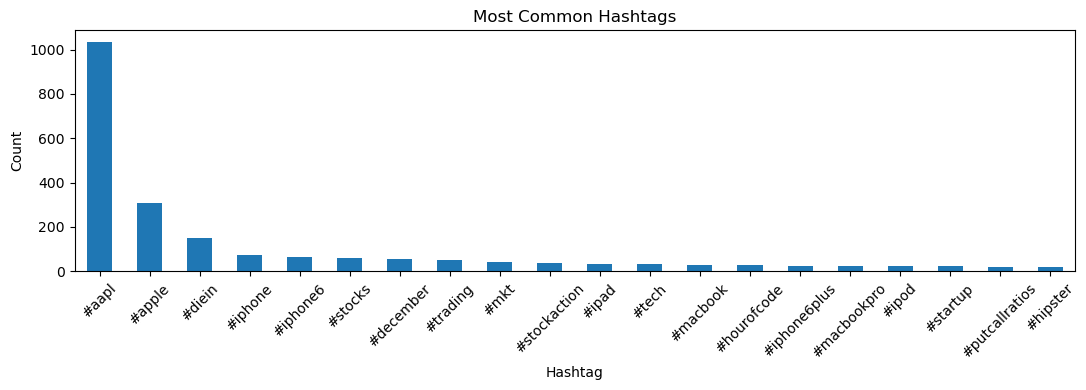

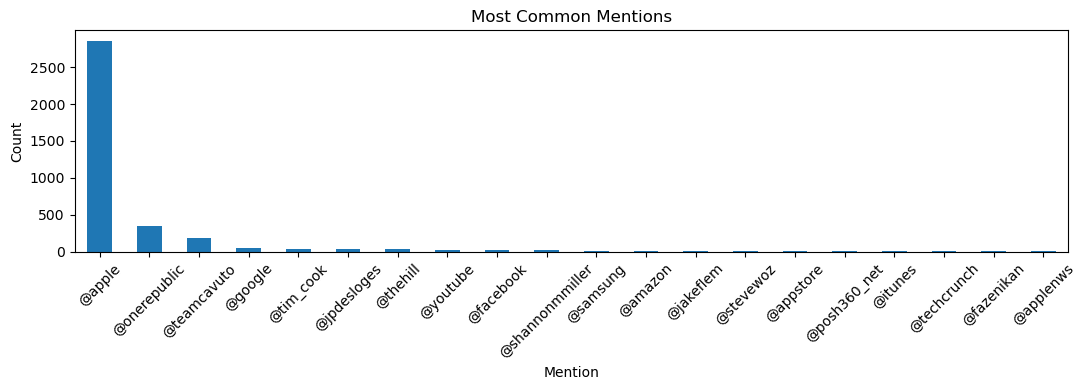

Top 20 Hashtag counts:
#aapl             1035
#apple             307
#diein             152
#iphone             74
#iphone6            64
#stocks             58
#december           54
#trading            52
#mkt                41
#stockaction        36
#ipad               35
#tech               31
#macbook            27
#hourofcode         26
#iphone6plus        24
#macbookpro         23
#ipod               22
#startup            22
#putcallratios      21
#hipster            20
Name: 0, dtype: int64

Top 20 Mention counts:
@apple             2856
@onerepublic        355
@teamcavuto         180
@google              50
@tim_cook            40
@jpdesloges          37
@thehill             33
@youtube             24
@facebook            19
@shannonmmiller      19
@samsung             15
@amazon              13
@jakeflem            12
@stevewoz            12
@appstore            12
@posh360_net         12
@itunes              12
@techcrunch          11
@fazenikan           11
@applenws      

In [9]:
# Extract words with '#' and '@' from the 'text' column
hashtags = df['text'].str.extractall(r'(\#\w+)')[0]
mentions = df['text'].str.extractall(r'(\@\w+)')[0]

# Count and display unique hashtags and mentions
hashtag_counts = hashtags.value_counts()
mention_counts = mentions.value_counts()

# Display only counts greater than 20
#hashtag_counts_greater_than_20 = hashtag_counts[hashtag_counts > 20]
#mention_counts_greater_than_20 = mention_counts[mention_counts > 20]

# Top 20 records for hashtags
hashtag_head = hashtag_counts.head(20)
# Top 20 records for mentions
mention_head = mention_counts.head(20)


# Create a bar chart for hashtag
pt.figure(figsize=(11, 4))
hashtag_head.plot(kind='bar')
pt.xlabel('Hashtag')
pt.ylabel('Count')
pt.title('Most Common Hashtags')
pt.xticks(rotation=45)
pt.tight_layout()
pt.show()


# Create a bar chart for mentions
pt.figure(figsize=(11, 4))
mention_head.plot(kind='bar')
pt.xlabel('Mention')
pt.ylabel('Count')
pt.title('Most Common Mentions')
pt.xticks(rotation=45)
pt.tight_layout()
pt.show()

print("Top 20 Hashtag counts:")
print(hashtag_counts.head(20))
print("\nTop 20 Mention counts:")
print(mention_counts.head(20))

The top 20 hashtags and mentions are analyzed to gain insights into trending topics during the data set tweet time-frame. The hashtags that appeared most frequently in the tweets were predominantly related to Apple, Apple products, and the stock market.  

The mention counts revealed notable Twitter accounts that were frequently tagged in the tweets. Two Apple executives were trending during this time period. The most mentioned Twitter account was @apple, followed by @onerepublic and @teamcavuto, with significant engagement.


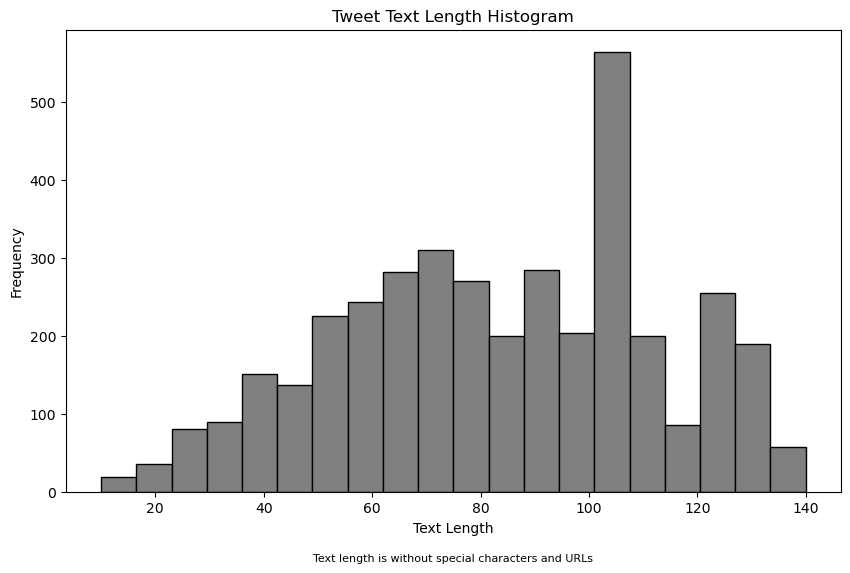

In [10]:
# Remove special characters, data prep for distribution of tweet lengths
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Calculate the length of tweet 
df['text_length'] = df['text'].apply(len)

# Create a histogram of the tweet lengths 
pt.figure(figsize=(10,6))
pt.hist(df['text_length'], bins = 20, color = 'grey', edgecolor = 'black')
pt.xlabel('Text Length')
pt.ylabel('Frequency')
pt.title('Tweet Text Length Histogram')
subtitle = "Text length is without special characters and URLs"
pt.text(0.5, -0.15, subtitle, ha='center', fontsize=8, transform=pt.gca().transAxes)
pt.show()

To conclude the exploratory data analysis of the tweets, the distribution of tweet lengths after removing special characters and URLs from the text are visualized. The analysis revealed a slight outlier in the distribution, with a notable concentration of tweets ranging from 100 to 110 characters in length.

### Sentiment Analysis 

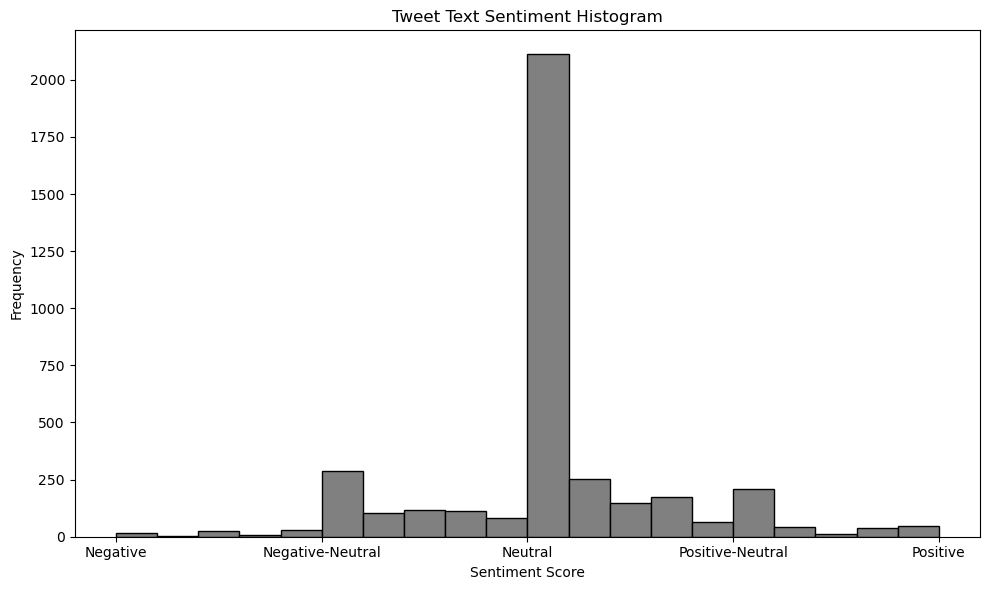

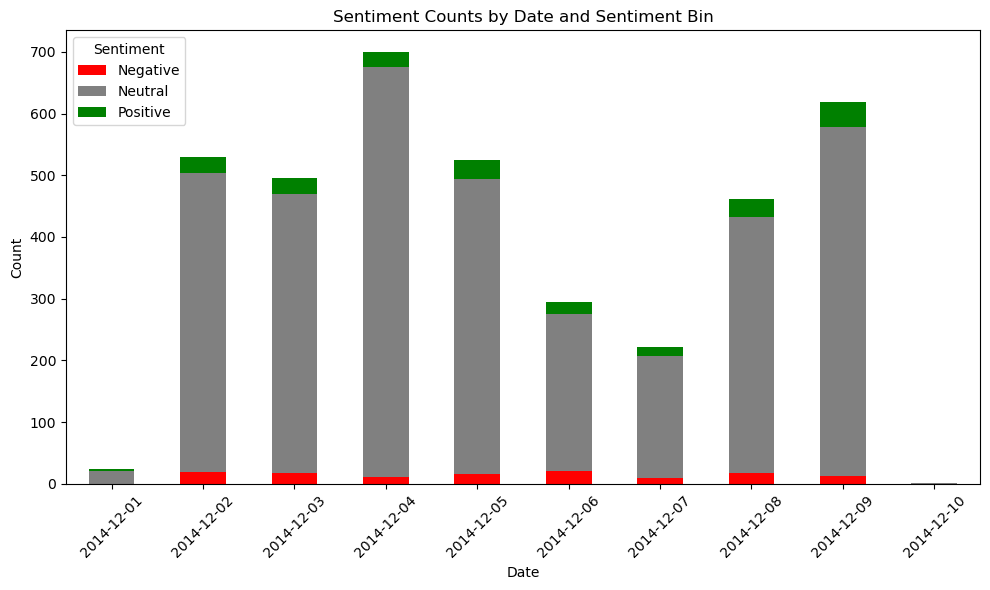

sentiment   Negative  Neutral  Positive
date2                                  
2014-12-01      0.00    83.33     16.67
2014-12-02      3.59    91.68      4.73
2014-12-03      3.43    91.13      5.44
2014-12-04      1.57    95.00      3.43
2014-12-05      2.86    91.41      5.73
2014-12-06      7.14    86.39      6.46
2014-12-07      4.07    89.59      6.33
2014-12-08      3.90    89.61      6.49
2014-12-09      1.94    91.60      6.46
2014-12-10      0.00   100.00      0.00


In [31]:
# Perform sentiment analysis on the text column
df['sentiment'] = df['text'].apply(lambda x: sentiment(x)[0])
#print(df.head())

# Create a histogram of the sentiment scores
pt.figure(figsize=(10, 6))
pt.hist(df['sentiment'], bins=20, color='grey', edgecolor='black')
pt.xlabel('Sentiment Score')
pt.ylabel('Frequency')
pt.title('Tweet Text Sentiment Histogram')
pt.xticks([-1, -0.5, 0, 0.5, 1], ['Negative', 'Negative-Neutral', 'Neutral', 'Positive-Neutral', 'Positive'])  # Label bins
pt.tight_layout()
pt.show()

# Define sentiment bins
bins = [-1, -0.5, 0.5, 1]
labels = ['Negative', 'Neutral', 'Positive']

# Group by 'date2' and sentiment bins, then count the records by day
sentiment_counts = df.groupby(['date2', pd.cut(df['sentiment'], bins=bins, labels=labels)]).size().unstack(fill_value=0)

# Bar chart of the sentiment scores bins by day 
colors = {'Negative': 'red', 'Neutral': 'gray', 'Positive': 'green'}
ax = sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[col] for col in sentiment_counts.columns])
pt.xlabel('Date')
pt.ylabel('Count')
pt.title('Sentiment Counts by Date and Sentiment Bin')
pt.legend(title='Sentiment')
pt.xticks(rotation=45)
pt.tight_layout()
pt.show()

# Sentiment scores by date and bin 
sentiment_percentages = (sentiment_counts.divide(sentiment_counts.sum(axis=1), axis=0) * 100).round(2)
print(sentiment_percentages)

Using the 'pattern' library package, the sentiment function to the tweet text. This function categorized more than two thousand tweets as 'neutral.' After assigning sentiment scores to each tweet, the tweets are aggregated by day to calculate the percentage of daily positive, negative, and neutral tweets. Over the ten-day period, more than 80% of the daily tweets were classified as 'neutral,' with the remaining tweets being divided into slightly more 'positive' tweets compared to 'negative' sentiment.

     unit_id                                               text       date2  \
0  623495513             aaplthe 10 best steve jobs emails ever  2014-12-01   
1  623495514  rt jpdesloges why aapl stock had a miniflash c...  2014-12-01   
2  623495515    my cat only chews apple cords such an applesnob  2014-12-01   
3  623495516  i agree with jimcramer that the individualinve...  2014-12-01   
4  623495517        nobody expects the spanish inquisition aapl  2014-12-01   

        date_time  text_length  sentiment  vader_sentiment_score  \
0  19:30:03 +0000           38       1.00                 0.6369   
1  19:43:51 +0000           67       0.00                -0.4019   
2  19:50:28 +0000           47       0.00                 0.0000   
3  20:26:34 +0000          129       0.65                 0.6597   
4  20:29:33 +0000           43       0.00                -0.2960   

   sent_difference  
0           0.3631  
1           0.4019  
2           0.0000  
3          -0.0097  
4          

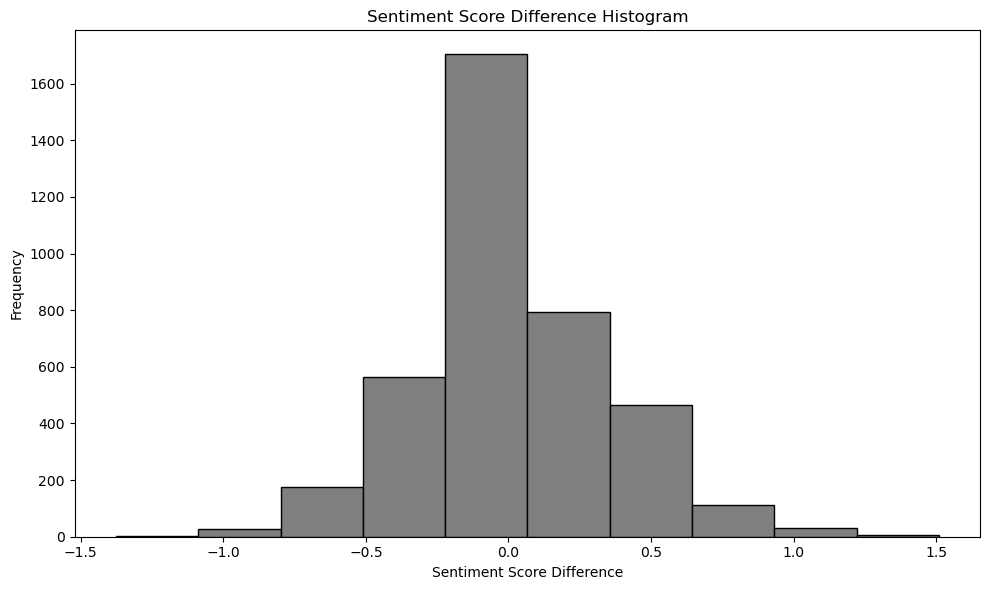

In [12]:
# Using additional library package Vader to compare results of the pattern library sentiment scores to another platform 
calc = sia()

def vader_sentiment_score(text):
    sentiment = calc.polarity_scores(text)
    return sentiment ['compound']

df['vader_sentiment_score'] = df['text'].apply(vader_sentiment_score)

# Calculate the difference between the sentiment provided by pattern and the sentiment score through vader
df['sent_difference'] = df['sentiment'] - df['vader_sentiment_score']
print(df.head())

# Create a histogram of the sentiment scores
pt.figure(figsize=(10, 6))
pt.hist(df['sent_difference'], bins=10, color='grey', edgecolor='black')
pt.xlabel('Sentiment Score Difference')
pt.ylabel('Frequency')
pt.title('Sentiment Score Difference Histogram')
#pt.xticks([-1, -0.5, 0, 0.5, 1], ['Negative', 'Negative-Neutral', 'Neutral', 'Positive-Neutral', 'Positive'])  # Label bins
pt.tight_layout()
pt.show()

To validate the sentiment scores obtained from the 'pattern' library package, a secondary sentiment analysis package, 'Vader' library is utilized. The 'polarity_score' function from 'Vader,' is ran on the tweet text similiary to 'pattern.' The histogram visualizes the differences between the two sets of scores, revealing a normal distribution centered around '0.0.' Suggesting in the majority of cases, there is minimal to no divergence between the sentiment scores computed by these two distinct packages.

### Stock Analysis Correlation 

In [45]:
def daily_returns(symbols, start, end):
    data = download(tickers=symbols, start=start, end=end)
    
    if 'Adj Close' in data.columns:
        data['daily_return'] = (data['Adj Close'].pct_change() * 100).round(2)
        data['return'] = data['daily_return'].apply(lambda x: 'negative' if x < 0 else ('positive' if x > 0 else 'no change'))
    else:
        return None
    
    return data

min_date = df['date2'].min()
max_date = pd.to_datetime(df['date2'].max()) + pd.DateOffset(days=1)
symbols = ['AAPL']
start = min_date 
end = max_date

daily_returns = daily_returns(symbols, start, end)
columns_to_drop = ['Open','High','Low','Close','Adj Close','Volume','daily_return']
daily_returns = daily_returns.drop(columns = columns_to_drop)
print(daily_returns)

[*********************100%%**********************]  1 of 1 completed
               return
Date                 
2014-12-01  no change
2014-12-02   negative
2014-12-03   positive
2014-12-04   negative
2014-12-05   negative
2014-12-08   negative
2014-12-09   positive
2014-12-10   negative


In [62]:
sentiment_percentages.index = pd.to_datetime(sentiment_percentages.index)

cor_data = pd.merge(sentiment_percentages, daily_returns, left_index=True, right_on='Date', how='inner')
cor_data = cor_data.drop('date2', axis=1)

cor_data['return'] = cor_data['return'].map({'no change': 0, 'negative': -1, 'positive': 1})

correlation_matrix = cor_data[['Negative', 'Neutral', 'Positive', 'return']].corr()

sentiment_return_correlation = correlation_matrix.loc[['Negative', 'Neutral', 'Positive'], 'return']

print(sentiment_return_correlation)


Negative   -0.006648
Neutral    -0.325485
Positive    0.323351
Name: return, dtype: float64


From the correlation analysis there is little to no significant linear correlation between the sentiment percentages (Negative, Neutral, Positive) of tweets and the daily returns of the stock. In summary, while there are some weak to moderate correlations between sentiment percentages and daily stock returns, these correlations are not strong enough to make definitive predictions about stock performance based solely on tweet sentiment. Other factors and variables likely play a more significant role in determining stock returns, and sentiment analysis alone may not be sufficient for making investment decisions.

## Summary

Overall, the sentiment analysis was strongly leaning towards neutral tweets with most cases being less than 20% of 'positive' and 'negative' sentiments identified. This could be due to the length of tweets being limited to a certain number of characters and contain a number of stop words. 

There was little to no siginificant correlation that was identified between the daily sentiment scores and stock performance during this time. The high number of neutral tweets could skew these results, especially since during the EDA the top hashtags returned results relating to the stock market. 